In [1]:
import pymaltspro as pmp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle as pkl
from multiprocessing import Pool

In [2]:
def barycenter_imputation(pmp_self, X_estimation, Y_estimation, MG):
    Y_counterfactual = []
    for i in X_estimation.index.values:
        # make a holder list for adding matched units' outcomes
        matched_unit_ids = MG.query(f'unit == {i}').query(pmp_self.treatment + ' != unit_treatment').matched_unit.values
        matched_unit_outcomes = Y_estimation[matched_unit_ids, :]
        y_i_counterfactual = pmp.wasserstein2_barycenter(
            sample_array_1_through_n = matched_unit_outcomes, 
            weights = np.repeat(1/matched_unit_outcomes.shape[0], matched_unit_outcomes.shape[0]),
            n_samples_min=pmp_self.n_samples_min
        )
        Y_counterfactual.append(y_i_counterfactual)
    return np.array(Y_counterfactual)

def sample_quantile(quantile_fn, quantile):
    '''
    description
    -----------
    linearly interpolate quantile function and return value of a given quantile
    
    parameters
    ----------
    quantile_fn : numpy array with values of quantile function at specified quantiles
    quantile : value of quantile
    n_qtls : size of quantile function
    
    returns
    -------
    quantile function evaluated at specified quantile
    '''
    n_qtls = quantile_fn.shape[0] - 1
    quantile_index = quantile * n_qtls
    quantile_floor = int(np.floor(quantile_index))
    quantile_ceil  = int(np.ceil(quantile_index))
    if quantile_floor == quantile_ceil == quantile_index:
        return(quantile_fn[quantile_floor])
    else:
        return np.sum([quantile_fn[quantile_floor] * (quantile_index - quantile_floor), quantile_fn[quantile_ceil] * (quantile_ceil - quantile_index)])
def ITE(pmp_self, y_true, y_impute, n_mc_samples, obs_treatment, y_true_qtl_id = False, y_impute_qtl_id = False):
    if y_true_qtl_id == False:
        y_true_qtl_fn = np.quantile(y_true, q = np.arange(pmp_self.n_samples_min)/pmp_self.n_samples_min)
    else:
        y_true_qtl_fn = y_true
    
    if y_impute_qtl_id == False:
        y_impute_qtl_fn = np.quantile(y_impute, q = np.arange(pmp_self.n_samples_min)/pmp_self.n_samples_min)
    else:
        y_impute_qtl_fn = y_impute
    
    qtls_to_sample = np.random.uniform(low = 0, high = 1, size = n_mc_samples)
    if obs_treatment == 1:
        y_treat = np.array([sample_quantile(quantile_fn = y_true_qtl_fn, quantile = q) for q in qtls_to_sample])
        y_control = np.array([sample_quantile(quantile_fn = y_impute_qtl_fn, quantile = q) for q in qtls_to_sample])
    else:
        y_treat = np.array([sample_quantile(quantile_fn = y_impute_qtl_fn, quantile = q) for q in qtls_to_sample])
        y_control = np.array([sample_quantile(quantile_fn = y_true_qtl_fn, quantile = q) for q in qtls_to_sample])
        
    return (y_treat > y_control).mean()

#### Simulation Setup: multiple continuous covariates
- for i = 1...n
    - $x_{i0},...,x_{i10} \sim Unif[0, 1]$
    - $error_{a,i} \sim Normal(0, 1)$
    - $error_{y, i} \sim Normal(0, 1)^2$: $\chi^2$ with 1 df
    - $a_i = 1(expit(x_{i0} + x_{i1} + error_{a, i}) > 0.5)$
    - if $a_i = 0$
        - $$y_i = Beta(sin(pi * x_{i1) * x_{i2}) + 20(x_{i3} - 0.5)^2 + 10x_{i4} + 5x_{i5} + error_{y, i}, 
                      sin(pi * x_{i1) * x_{i2}) + 20(x_{i3} - 0.5)^2 + 10x_{i4} + 5x_{i5} + error_{y, i})$$
        - $E_{Y_i(0)}[Y_i(0)] = 1/2$
    - if $a_i = 1$
        - $y_i = Exp(1/(0.5 + error_{y, i})) - 1$
        - $E_{Y_i(1)}[Y_i(1)] = 1/2 + error_y - 1$
        - $E_i[E_{Y_i(1)}[Y_i(1)] | X] = E_i[1/2 + error_{y,i} - 1] = 1/2 + 1 - 1 = 1/2$

In [3]:
def maltspro_parallel(dataset_iteration):
    print(dataset_iteration, end = ' ')
    seed = 2020 + 1000 * dataset_iteration
    np.random.seed(seed)
    n_units = 1000
    n_obs_y = 1001
    y0_param = np.array([-1])
    y1_param = np.array([-1])
    while sum(y0_param <= 0) != 0 and sum(y1_param <= 0) != 0:
        X = np.random.uniform(low = 0, high = 1, size = [n_units, 11])
        error_a = np.random.normal(loc = 0, scale = 1, size = n_units)
        error_y = np.random.normal(loc = 0, scale = 1, size = n_units)**2 # sample from chi square w/1 df; error_y > 0
        A = (1/(1 + np.exp(-1 * (X[:, 0] + X[:, 1] + error_a))) > 0.5).astype(int)
        y0_param = (np.sin(np.pi * X[:, 1] * X[:, 2]) + 20*(X[:, 3] - 0.5)**2 + 10*X[:, 4] + error_y**2)
#         y1_param = 30 * (np.sin(np.pi * X[:, 1] * X[:, 2]) + 20*(X[:, 3] - 0.5)**2 + 10*X[:, 4] + np.cos(np.pi * X[:, 1] * X[:, 2]) + error_y**2)
        y1_param = 1/(0.5 + error_y)
    y0 = np.array([np.random.beta(a = y0_param[i], b = y0_param[i], size = n_obs_y) for i in range(n_units)])
#     y1 = np.array([np.random.beta(a = y1_param[i], b = y1_param[i], size = n_obs_y) for i in range(n_units)]) - 1
    y1 = np.array([np.random.exponential(scale = y1_param[i], size = n_obs_y) for i in range(n_units)]) - 1
    y = np.array([y0[i, :] if A[i] == 0  else y1[i, :] for i in range(n_units)])
    y_unobs = np.array([y0[i, :] if A[i] == 1  else y1[i, :] for i in range(n_units)])
    maltspro_df = pd.DataFrame(np.hstack([X,A.reshape([n_units, 1])]), columns=list('X_' + str(i) for i in range(11)) + ['A'])

    if 'dataset_' + str(seed) not in os.listdir('./experiments/cont_features/.'):
        os.mkdir('./experiments/cont_features/dataset_' + str(seed))
    maltspro_df.to_csv('./experiments/cont_features/dataset_' + str(seed) + '/X.csv', index = False)
    pd.DataFrame(y).to_csv('./experiments/cont_features/dataset_' + str(seed) + '/Y.csv', index = False)

    np.random.seed(999)
        
    # split into training and estimation datasets: 20% for training, 80% for estimation
    train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
    est_indexes = list(set(range(n_units)) - set(train_indexes))
    X_train = maltspro_df.iloc[train_indexes, :].reset_index()
    X_est = maltspro_df.iloc[est_indexes, :].reset_index()
    y_train = y[train_indexes, :]
    y_est = y[est_indexes, :]
    y_unobs_est = y_unobs[est_indexes, :]
    
    # run MALTSPro
    maltspro = pmp.pymaltspro(X = X_train,
                              y = y_train, 
                              treatment = 'A', 
                              discrete = [],
                              C = 0.001,
                              k = 10)

    maltspro.fit(method = 'SLSQP')
        
    # save maltspro
    pkl_file = open('./experiments/cont_features/dataset_' + str(seed) + '/malts_model.pkl', 'wb')
    pkl.dump(maltspro, file = pkl_file)
    
    # get matched groups
    mg_df = maltspro.get_matched_groups(X_estimation=X_est,
                                        Y_estimation= y_est,
                                        k =10)
    
    
    # impute counterfactuals using barycenter of k nn
    y_bary = barycenter_imputation(pmp_self = maltspro, 
                                   X_estimation=X_est,
                                   Y_estimation= y_est,
                                   MG = mg_df)
    
    # estimate the ITE with known counterfactuals
    ITE_true = []
    for i in range(len(est_indexes)):
        ITE_true.append(
            ITE(pmp_self = maltspro, 
                y_true = y_est[i, :],
                y_impute = y_unobs_est[i, :],
                n_mc_samples = 10000,
                obs_treatment = X_est.loc[i, 'A'],
                y_true_qtl_id = False,
                y_impute_qtl_id = False)
            )
    ITE_true = np.array(ITE_true)
    ATE_true = ITE_true.mean()
    print('True ATE:', ATE_true, end = ' ')
    # estimate ITE with MALTS' counterfactual 
    ITE_malts = []
    for i in range(len(est_indexes)):
        ITE_malts.append(
            ITE(pmp_self = maltspro, 
                y_true = y_est[i, :],
                y_impute = y_bary[i, :],
                n_mc_samples = 10000,
                obs_treatment = X_est.loc[i, 'A'],
                y_true_qtl_id = False,
                y_impute_qtl_id = False)
            )
    ITE_malts = np.array(ITE_malts)
    ATE_malts = ITE_malts.mean()
    print('MALTSPro ATE:', ATE_malts)
    
    ITE_df = pd.DataFrame({'ITE_true' : ITE_true, 'ITE_malts' : ITE_malts})
    ITE_df.to_csv('./experiments/cont_features/dataset_' + str(seed) + '/ITE.csv', index = False)
    
    # delete objects locally
    del(seed)
    del(n_units)
    del(n_obs_y)
    del(X)
    del(error_a)
    del(error_y)
    del(A)
    del(y0_param)
    del(y1_param)
    del(y0)
    del(y1)
    del(y)
    del(y_unobs)
    del(train_indexes)
    del(est_indexes)
    del(X_train)
    del(X_est)
    del(y_train)
    del(y_est)
    del(y_unobs_est)
    del(maltspro)
    del(y_bary)
    del(ITE_malts)
    del(ITE_true)
    del(ATE_malts)
    del(ATE_true)
    del(ITE_df)
    

In [4]:
if __name__ == '__main__':
    dataset_iterations_to_conduct = range(48, 100)
    with Pool(processes = 4) as pool:
        pool.map(maltspro_parallel, dataset_iterations_to_conduct)

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/skatta/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  

  File "<__array_function__ internals>", line 6, in apply_along_axis
  File "<__array_function__ internals>", line 6, in apply_along_axis
  File "/Users/skatta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py", line 402, in apply_along_axis
    buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
  File "/Users/skatta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py", line 402, in apply_along_axis
    buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
  File "<__array_function__ internals>", line 6, in apply_along_axis
  File "/Users/skatta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/shape_base.py", line 402, in apply_along_axis
    buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))
  File "/Users/skatta/Dropbox/ame/dmalts/MALTSPro/pymaltspro.py", line 144, in <lambda>
    q = np.linspace(start = 0, stop = 1, num = n_samples_min)
  File "/Users/skatta/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/sh

KeyboardInterrupt: 

In [ ]:
# # create dataset
# for dataset_iteration in range(1, 100):
#     print(dataset_iteration, end = ' ')
#     seed = 2020 + 1000 * dataset_iteration
#     np.random.seed(seed)
#     n_units = 1000
#     n_obs_y = 1001
#     y0_param = np.array([-1])
#     y1_param = np.array([-1])
#     while sum(y0_param <= 0) != 0 and sum(y1_param <= 0) != 0:
#         X = np.random.uniform(low = 0, high = 1, size = [n_units, 11])
#         error_a = np.random.normal(loc = 0, scale = 1, size = n_units)
#         error_y = np.random.normal(loc = 0, scale = 1, size = n_units)**2 # sample from chi square w/1 df; error_y > 0
#         A = (1/(1 + np.exp(-1 * (X[:, 0] + X[:, 1] + error_a))) > 0.5).astype(int)
#         y0_param = (np.sin(np.pi * X[:, 1] * X[:, 2]) + 20*(X[:, 3] - 0.5)**2 + 10*X[:, 4] + error_y**2)
# #         y1_param = 30 * (np.sin(np.pi * X[:, 1] * X[:, 2]) + 20*(X[:, 3] - 0.5)**2 + 10*X[:, 4] + np.cos(np.pi * X[:, 1] * X[:, 2]) + error_y**2)
#         y1_param = 1/(0.5 + error_y)
#     y0 = np.array([np.random.beta(a = y0_param[i], b = y0_param[i], size = n_obs_y) for i in range(n_units)])
# #     y1 = np.array([np.random.beta(a = y1_param[i], b = y1_param[i], size = n_obs_y) for i in range(n_units)]) - 1
#     y1 = np.array([np.random.exponential(scale = y1_param[i], size = n_obs_y) for i in range(n_units)]) - 1
#     y = np.array([y0[i, :] if A[i] == 0  else y1[i, :] for i in range(n_units)])
#     y_unobs = np.array([y0[i, :] if A[i] == 1  else y1[i, :] for i in range(n_units)])
#     maltspro_df = pd.DataFrame(np.hstack([X,A.reshape([n_units, 1])]), columns=list('X_' + str(i) for i in range(11)) + ['A'])

#     if 'dataset_' + str(seed) not in os.listdir('./experiments/cont_features/.'):
#         os.mkdir('./experiments/cont_features/dataset_' + str(seed))
#     maltspro_df.to_csv('./experiments/cont_features/dataset_' + str(seed) + '/X.csv', index = False)
#     pd.DataFrame(y).to_csv('./experiments/cont_features/dataset_' + str(seed) + '/Y.csv', index = False)

#     np.random.seed(999)
        
#     # split into training and estimation datasets: 20% for training, 80% for estimation
#     train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
#     est_indexes = list(set(range(n_units)) - set(train_indexes))
#     X_train = maltspro_df.iloc[train_indexes, :].reset_index()
#     X_est = maltspro_df.iloc[est_indexes, :].reset_index()
#     y_train = y[train_indexes, :]
#     y_est = y[est_indexes, :]
#     y_unobs_est = y_unobs[est_indexes, :]
    
#     # run MALTSPro
#     maltspro = pmp.pymaltspro(X = X_train,
#                               y = y_train, 
#                               treatment = 'A', 
#                               discrete = [],
#                               C = 0.001,
#                               k = 10)

#     maltspro.fit(method = 'SLSQP')
        
#     # save maltspro
#     pkl_file = open('./experiments/cont_features/dataset_' + str(seed) + '/malts_model.pkl', 'wb')
#     pkl.dump(maltspro, file = pkl_file)
    
#     # get matched groups
#     mg_df = maltspro.get_matched_groups(X_estimation=X_est,
#                                         Y_estimation= y_est,
#                                         k =10)
    
    
#     # impute counterfactuals using barycenter of k nn
#     y_bary = barycenter_imputation(pmp_self = maltspro, 
#                                    X_estimation=X_est,
#                                    Y_estimation= y_est,
#                                    MG = mg_df)
    
#     # estimate the ITE with known counterfactuals
#     ITE_true = []
#     for i in range(len(est_indexes)):
#         ITE_true.append(
#             ITE(pmp_self = maltspro, 
#                 y_true = y_est[i, :],
#                 y_impute = y_unobs_est[i, :],
#                 n_mc_samples = 10000,
#                 obs_treatment = X_est.loc[i, 'A'],
#                 y_true_qtl_id = False,
#                 y_impute_qtl_id = False)
#             )
#     ITE_true = np.array(ITE_true)
#     ATE_true = ITE_true.mean()
#     print('True ATE:', ATE_true, end = ' ')
#     # estimate ITE with MALTS' counterfactual 
#     ITE_malts = []
#     for i in range(len(est_indexes)):
#         ITE_malts.append(
#             ITE(pmp_self = maltspro, 
#                 y_true = y_est[i, :],
#                 y_impute = y_bary[i, :],
#                 n_mc_samples = 10000,
#                 obs_treatment = X_est.loc[i, 'A'],
#                 y_true_qtl_id = False,
#                 y_impute_qtl_id = False)
#             )
#     ITE_malts = np.array(ITE_malts)
#     ATE_malts = ITE_malts.mean()
#     print('MALTSPro ATE:', ATE_malts)
    
#     ITE_df = pd.DataFrame({'ITE_true' : ITE_true, 'ITE_malts' : ITE_malts})
#     ITE_df.to_csv('./experiments/cont_features/dataset_' + str(seed) + '/ITE.csv', index = False)
    
#     # delete objects locally
#     del(seed)
#     del(n_units)
#     del(n_obs_y)
#     del(X)
#     del(error_a)
#     del(error_y)
#     del(A)
#     del(y0_param)
#     del(y1_param)
#     del(y0)
#     del(y1)
#     del(y)
#     del(y_unobs)
#     del(train_indexes)
#     del(est_indexes)
#     del(X_train)
#     del(X_est)
#     del(y_train)
#     del(y_est)
#     del(y_unobs_est)
#     del(maltspro)
#     del(y_bary)
#     del(ITE_malts)
#     del(ITE_true)
#     del(ATE_malts)
#     del(ATE_true)
#     del(ITE_df)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [10]:
cont_exp_files = os.listdir('./experiments/cont_features/')
cont_exp_dfs = []
for folder in cont_exp_files:
    cont_exp_dfs.append(pd.read_csv(f'./experiments/cont_features/{folder}/ITE.csv').assign(df = folder))
ITE_df = pd.concat(cont_exp_dfs)

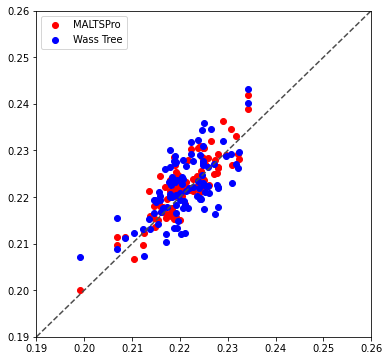

In [31]:
ATE_df = ITE_df.groupby('df').mean()
f, ax = plt.subplots(figsize = (6, 6))

ax.scatter(ATE_df['ITE_true'].values, ATE_df['ITE_malts'].values, c = 'r', label = 'MALTSPro')
ax.scatter(ATE_df['ITE_true'].values, ATE_df['ITE_wass_tree'].values, c = 'b', label = 'Wass Tree')
ax.plot([0.19,0.26], [0.19,.26], ls = '--', c = '.3')
ax.set(xlim = (0.19, 0.26), ylim = (0.19, 0.26))
plt.legend()

In [35]:
import numpy as np
np.apply_along_axis(arr = np.array([[1, 2, np.nan], [2, 4, 6]]), func1d = lambda x: x[x == x].shape[0], axis = 1)

array([2, 3])

In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl
from multiprocessing import Pool

def knn_predict(n_samples_min, query_x, query_treatment, X, y, treatment_var, k):
    '''
    description
    -----------
    predict distributional outcome using k-nearest neighbors matching
    
    parameters
    ----------
    query_x : covariates for query point
    query_treatment : treatment assignment that query point should predict for
    X : dataset of training covariates
    y : corresponding outcomes of units in X
        should already be converted to quantile functions: N by k_i
    treatment_var : string name of treatment variable
    k : number of nearest neighbors to match with
    '''
    # separate treatment assignments from covariates
    treatment_vector = X[treatment_var].values
    X = X.drop(treatment_var, axis = 1)
    
    # calculate distance between query_x and all units in X using L2 distance
    distance_vector = []
    unit_ids = []
    for i in X.shape[0]:
        if treatment_vector[i] == query_treatment:
            distance_vector.append(np.linalg.norm(query_x - X.iloc[i, :]))
    
    # find k closest units
    k_nn_ids = pd.DataFrame(
        {
            'unit_id'  : unit_ids,
            'distance' : distance_vector
        }
    ).sort_values('distance').iloc[:k, 0].values
    
    # find corresponding y
    k_nn_y = []
    for i in k_nn_ids:
        k_nn_y.append(y[i, :])
    k_nn_y = np.array(k_nn_y)
    
    # compute barycenter of corresponding y
    bary = np.mean(k_nn_y, axis = 1)
    
    # return barycenter
    return bary

def sample_quantile(quantile_fn, quantile):
    '''
    description
    -----------
    linearly interpolate quantile function and return value of a given quantile
    
    parameters
    ----------
    quantile_fn : numpy array with values of quantile function at specified quantiles
    quantile : value of quantile
    n_qtls : size of quantile function
    
    returns
    -------
    quantile function evaluated at specified quantile
    '''
    n_qtls = quantile_fn.shape[0] - 1
    quantile_index = quantile * n_qtls
    quantile_floor = int(np.floor(quantile_index))
    quantile_ceil  = int(np.ceil(quantile_index))
    if quantile_floor == quantile_ceil == quantile_index:
        return(quantile_fn[quantile_floor])
    else:
        return np.sum([quantile_fn[quantile_floor] * (quantile_index - quantile_floor), quantile_fn[quantile_ceil] * (quantile_ceil - quantile_index)])
def ITE(n_samples_min, y_true, y_impute, n_mc_samples, obs_treatment, y_true_qtl_id = False, y_impute_qtl_id = False):
    if y_true_qtl_id == False:
        y_true_qtl_fn = np.quantile(y_true, q = np.arange(n_samples_min)/n_samples_min)
    else:
        y_true_qtl_fn = y_true
    
    if y_impute_qtl_id == False:
        y_impute_qtl_fn = np.quantile(y_impute, q = np.arange(n_samples_min)/n_samples_min)
    else:
        y_impute_qtl_fn = y_impute
    
    qtls_to_sample = np.random.uniform(low = 0, high = 1, size = n_mc_samples)
    if obs_treatment == 1:
        y_treat = np.array([sample_quantile(quantile_fn = y_true_qtl_fn, quantile = q) for q in qtls_to_sample])
        y_control = np.array([sample_quantile(quantile_fn = y_impute_qtl_fn, quantile = q) for q in qtls_to_sample])
    else:
        y_treat = np.array([sample_quantile(quantile_fn = y_impute_qtl_fn, quantile = q) for q in qtls_to_sample])
        y_control = np.array([sample_quantile(quantile_fn = y_true_qtl_fn, quantile = q) for q in qtls_to_sample])
        
    return (y_treat > y_control).mean()

### Wasserstein random forest experiments
def knn_parallel(dataset_iteration):
    print(dataset_iteration, end = ' ')
    seed = 2020 + 1000 * dataset_iteration

    # read dataset
    maltspro_df = pd.read_csv('./experiments/cont_features/dataset_' + str(seed) + '/X.csv')
    y = pd.read_csv('./experiments/cont_features/dataset_' + str(seed) + '/Y.csv').to_numpy()

    n_units = maltspro_df.shape[0]
    # make training, estimation split
    # split into training and estimation datasets: 20% for training, 80% for estimation
    train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
    est_indexes = list(set(range(n_units)) - set(train_indexes))

    X_train = maltspro_df.iloc[train_indexes, :].reset_index().drop('index', axis = 1)
    X_est = maltspro_df.iloc[est_indexes, :].reset_index().drop('index', axis = 1)

    y_train = y[train_indexes, :]
    y_est = y[est_indexes, :]

    # turn y_est into quantile function
    n_min_samples = np.apply_along_axis(func1d = lambda x: x[x == x].shape[0],
                                        axis = 1, 
                                        arr = y_est).min()
    
    y_est_qtls = np.apply_along_axis(func1d = lambda x: np.quantile(x[x == x], np.linspace(0, 1, n_min_samples)),
                                        axis = 1, 
                                        arr = y_est)
    # impute counterfactuals
    y_knn_bary = []
    for i in range(X_est.shape[0]):
        y_knn_bary.append(knn_predict(n_samples_min = n_min_samples,
                    query_x = X_est.iloc[i, :],
                    query_treatment = X_est['A'].values[i],
                    X = X_est.drop('A', axis = 1),
                    y = y_est_qtls,
                    treatment_var = 'A',
                    k = 10))
    y_knn_bary = np.array(y_knn_bary)

    # measure P(A > B | A ~ Y_i(1), B ~ Y_i(0)) for units i in estimation set
    ITE_knn = []
    for i in range(len(est_indexes)):
        ITE_knn.append(
            ITE(n_samples_min = n_samples_min,
                y_true = y_est[i, :],
                y_impute = y_knn_bary[i, :],
                n_mc_samples = 10000,
                obs_treatment = X_est.loc[i, 'A'],
                y_true_qtl_id = False,
                y_impute_qtl_id = True)
            )
    ITE_wass_tree = np.array(ITE_wass_tree)
    # add ITE to ITE dataset
    ITE_df = pd.read_csv('./experiments/cont_features/dataset_' + str(seed) + '/ITE.csv')
    ITE_df['ITE_wass_tree'] = ITE_wass_tree
    print(dataset_iteration, 'ATE_true - ATE_wasstree', ITE_df.ITE_true.mean() - ITE_df.ITE_wass_tree.mean())
    ITE_df.to_csv('./experiments/cont_features/dataset_' + str(seed) + '/ITE.csv', index = False)
if __name__ == '__main__':
    dataset_iterations_to_conduct = range(0, 100)
    with Pool(processes = 40) as pool:
        pool.map(wass_tree_parallel, dataset_iterations_to_conduct)


In [3]:
import pandas as pd
import numpy as np
from pymaltspro2 import linbo_ITE
import os
dataset_directory = './experiments/friedman_sim_dgp'
# for dataset_iteration in range(100):
#     print(dataset_iteration, end = ' ')
#     seed = 2020 + 1000 * dataset_iteration
#     np.random.seed(seed)
#     n_units = 1000
#     n_obs_y = 1001
#     y0_param = np.array([-1])
#     y1_param = np.array([-1])
#     while sum(y0_param <= 0) > 0 or sum(y1_param <= 0) > 0:
#         X = np.random.uniform(low = 0, high = 1, size = [n_units, 11])
#         error_a = np.random.normal(loc = 0, scale = 1, size = n_units)
#         error_y = np.random.normal(loc = 0, scale = 1, size = n_units)**2 # sample from chi square w/1 df; error_y > 0
#         # y0_param = (np.abs(np.sin(np.pi * X[:, 1] * X[:, 2])) + (X[:, 3] - 0.5)**2 + error_y**2)
#         # y1_param = (np.abs(np.sin(np.pi * X[:, 1] * X[:, 2])) + 20*(X[:, 3] - 0.5)**2 + np.abs(np.cos(np.pi * X[:, 1] * X[:, 2])) + error_y**2)
#         # y1_param = 1/(0.5 + error_y)
#         y0_param = 5 + 10 * np.sin(np.pi * X[:, 1] + X[:, 2])**2 + 20 * (X[:, 3] - 0.5)**2 + 10 * X[:, 4] + 5*X[:, 5] + error_y
#         y1_param = 5 + 10 * np.sin(np.pi * X[:, 1] + X[:, 2])**2 + 20 * (X[:, 3] - 0.5)**2 + 10 * X[:, 4] + 5*X[:, 5] + 10 * X[:, 3]*np.cos(np.pi * X[:, 1] * X[:, 2])**2 + error_y
#     A = np.random.binomial(n = 1, p = 1/(1 + np.exp(-1 * (X[:, 0] + X[:, 1] + error_a))), size = n_units)
#     mixture_id = np.random.binomial(size = n_obs_y, p = 0.25, n = 1)
#     y0 = np.array([np.random.beta(a = 2 * y0_param[i], b = 8 * y0_param[i], size = n_obs_y) for i in range(n_units)]) * mixture_id + \
#             np.array([np.random.beta(a = 8 * y0_param[i], b = 2 * y0_param[i], size = n_obs_y) for i in range(n_units)]) * (1 - mixture_id)
#     y1 = np.array([np.random.beta(a = 2 * y1_param[i], b = 8 * y1_param[i], size = n_obs_y) for i in range(n_units)]) * (1 - mixture_id) + \
#             np.array([np.random.beta(a = 8 * y1_param[i], b = 2 * y1_param[i], size = n_obs_y) for i in range(n_units)]) * (mixture_id)

#     print('got data')
#     # y1 = np.array([np.random.exponential(scale = y1_param[i], size = n_obs_y) for i in range(n_units)]) - 1
#     y = np.array([y0[i, :] if A[i] == 0  else y1[i, :] for i in range(n_units)])
#     y_unobs = np.array([y0[i, :] if A[i] == 1  else y1[i, :] for i in range(n_units)])
#     maltspro_df = pd.DataFrame(np.hstack([X,A.reshape([n_units, 1])]), columns=list('X_' + str(i) for i in range(11)) + ['A'])

#     if 'dataset_' + str(seed) not in os.listdir(dataset_directory + '/.'):
#         os.mkdir(dataset_directory + '/dataset_' + str(seed))
#     maltspro_df.to_csv(dataset_directory + '/dataset_' + str(seed) + '/X.csv', index = False)
#     pd.DataFrame(y).to_csv(dataset_directory + '/dataset_' + str(seed) + '/Y.csv', index = False)
#     pd.DataFrame(y_unobs).to_csv(dataset_directory + '/dataset_' + str(seed) + '/Y_unobs.csv', index = False)
#     np.random.seed(999)
        
#     # split into training and estimation datasets: 20% for training, 80% for estimation
#     train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
#     est_indexes = list(set(range(n_units)) - set(train_indexes))
#     X_train = maltspro_df.iloc[train_indexes, :].reset_index()
#     X_est = maltspro_df.iloc[est_indexes, :].reset_index()
#     y_train = y[train_indexes, :]
#     y_est = y[est_indexes, :]
#     y_unobs_est = y_unobs[est_indexes, :]
    
#     # estimate the ITE with known counterfactuals
#     ITE_true = []
#     for i in range(len(est_indexes)):
#         ITE_true.append(
#             linbo_ITE(
#                 y_obs = y_est[i, :],
#                 y_cf = y_unobs_est[i, :],
#                 observed_treatment = X_est['A'].values[i],
#                 reference_distribution = np.vstack([np.linspace(0, 1, n_obs_y), np.linspace(0, 1, n_obs_y)]),
#                 y_obs_qtl_id = False, 
#                 y_cf_qtl_id = False
#             )[1, :]
#         )
#     ITE_true = np.array(ITE_true)
#     ATE_true = ITE_true.mean(axis = 1)
#     print(dataset_iteration, ': True ATE min =', ATE_true.min(), ' ATE max = ', ATE_true.max())
    
#     ITE_df = pd.DataFrame(ITE_true, columns = np.linspace(0, 1, n_obs_y))
#     ITE_df.to_csv(dataset_directory + '/dataset_' + str(seed) + '/ITE.csv', index = False)

(1001,)
(1001,)


<AxesSubplot:xlabel='Y', ylabel='Density'>

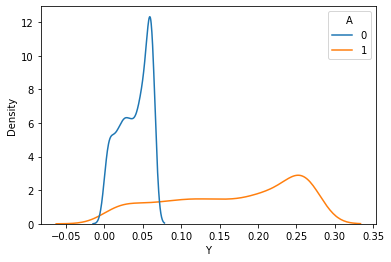

In [28]:
import seaborn as sns
import pandas as pd
import numpy as np

dataset_directory = './experiments/quadratic_sim_dgp'
Y = pd.read_csv(dataset_directory + '/dataset_2020/Y.csv')
Y_unobs = pd.read_csv(dataset_directory + '/dataset_2020/Y_unobs.csv')
X = pd.read_csv(dataset_directory + '/dataset_2020/X.csv')
i = 10
Y_treated = Y.iloc[np.where(X['A'] == 1)[0][i], :].to_numpy().reshape(-1)
print(Y_treated.shape)
Y_untreated = Y_unobs.iloc[np.where(X['A'] == 1)[0][i], :].to_numpy().reshape(-1)
print(Y_untreated.shape)
A = np.hstack([np.repeat(1, Y_treated.shape[0]), np.repeat(0, Y_untreated.shape[0])])
df = pd.DataFrame({
    'Y' : np.hstack([Y_treated, Y_untreated]),
    'A' : A
})
sns.kdeplot(data = df, x = 'Y', hue = 'A')
# plt.savefig(dataset_directory + '/density_plot.png')


In [1]:
import pandas as pd
import numpy as np
from pymaltspro2 import sample_quantile, ITE, linbo_ITE
import pickle as pkl
from multiprocessing import Pool
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

class ols_quantile():
    def __init__(self, qtl_grid, treatment_var):
        self.qtl_grid = np.array(qtl_grid)
        self.treatment_var = treatment_var
    
    def fit(self, X_train, Y_train):
        A_train = X_train[self.treatment_var].values
        X_train = X_train.drop(self.treatment_var, axis = 1)
        
        control = np.where(A_train == 0)[0]
        X_control = X_train.iloc[control, :]
        Y_control = Y_train[control, :]
        
        treated = np.where(A_train == 1)[0]
        X_treated = X_train.iloc[treated, :]
        Y_treated = Y_train[treated, :]
        
        self.OLS_control_list = []
        self.OLS_treated_list = []
        for q in range(self.qtl_grid.shape[0]):
            OLS_control = LinearRegression()
            OLS_control.fit(X_control, Y_control[:, q])
            self.OLS_control_list.append(OLS_control)
            
            OLS_treated = LinearRegression()
            OLS_treated.fit(X_treated, Y_treated[:, q])
            self.OLS_treated_list.append(OLS_treated)
        self.OLS_control_list = np.array(self.OLS_control_list)
        self.OLS_treated_list = np.array(self.OLS_treated_list)
    
    def predict_control(self, X_est):
        X_est = X_est.drop(self.treatment_var, axis = 1)
        Y_predict_control = np.ones(shape = [X_est.shape[0], self.qtl_grid.shape[0]])
        print(self.OLS_control_list.shape)
        for q in range(self.qtl_grid.shape[0]):
            Y_predict_control[:, q] = self.OLS_control_list[q].predict(X_est).reshape(Y_predict_control[:, q].shape)
        # Y_predict_control = np.apply_along_axis(func1d = lambda model: model.predict(X_est), axis = 0, arr = self.OLS_control_list)
        Y_predict_control = Y_predict_control.reshape([X_est.shape[0], self.qtl_grid.shape[0]])
        # for i in range(X_est.shape[0]):
        #     Y_control_i = []
            
        # for q in range(self.qtl_grid.shape[0]):
        #         Y_control_i.append(self.OLS_control_list[q].predict(X_est.iloc[i:(i+1), :]))
        #     Y_control_i = np.array(Y_control_i)
        #     Y_predict_control.append(Y_control_i)
        Y_predict_control = np.array(Y_predict_control)
        return Y_predict_control
            
    def predict_treated(self, X_est):
        X_est = X_est.drop(self.treatment_var, axis = 1)
        Y_predict_treated = np.ones(shape = [X_est.shape[0], self.qtl_grid.shape[0]])
        print(self.OLS_treated_list.shape)
        for q in range(self.qtl_grid.shape[0]):
            Y_predict_treated[:, q] = self.OLS_treated_list[q].predict(X_est).reshape(Y_predict_treated[:, q].shape)
        # Y_predict_treated = np.apply_along_axis(func1d = lambda model: model.predict(X_est), axis = 0, arr = self.OLS_treated_list)
        Y_predict_treated = Y_predict_treated.reshape([X_est.shape[0], self.qtl_grid.shape[0]])
        return Y_predict_treated
        
        
def ols_meta_predict(X_valid, wass_ols, treatment_var):
    y_pred = []
    # for i in range(X_valid.shape[0]):
    #     if X_valid.loc[i, treatment_var] == 1:
    #         # impute treated cf
    #         y_pred.append(wass_ols.predict_control(X_valid.iloc[i:(i+1), :])[0, :])
    #     else:
    #         # impute control cf
    #         y_pred.append(wass_ols.predict_treated(X_valid.iloc[i:(i+1), :])[0, :])
    A = X_valid[treatment_var].values
    A_repeat = np.array([np.repeat(A_i, repeats = wass_ols.qtl_grid.shape[0], axis = 0) for A_i in A])
    X_valid[treatment_var] = 0
    y_pred_control = wass_ols.predict_control(X_valid)
    X_valid[treatment_var] = 1
    y_pred_treated = wass_ols.predict_treated(X_valid)
    print(y_pred_treated.shape, y_pred_control.shape)
    y_pred = (1 - A_repeat) * y_pred_treated + A_repeat * y_pred_control
    return y_pred

### Wasserstein regression experiments
def wass_ols_parallel(dataset_iteration):
    print(dataset_iteration, end = ' ')
    seed = 2020 + 1000 * dataset_iteration

    # read dataset
    maltspro_df = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/X.csv')
    y = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/Y.csv').to_numpy()

    # turn into quantile functions
    #   1. find #quantiles
    n_samples_min = np.apply_along_axis(
                arr = y,
                axis = 1,
                func1d = lambda x: x[x == x].shape[0]).min()
    #   2. estimate quantile function at grid
    qtls = range(n_samples_min)
    y_qtl = np.apply_along_axis(
                    arr = y,
                    axis = 1,
                    func1d = lambda x: np.quantile(
                        a = x, 
                        q = np.linspace(start = 0, stop = 1, num = n_samples_min)
                        )
                    ).reshape(y.shape)

    n_units = maltspro_df.shape[0]
    # make training, estimation split

    print('training')
    # split into training and estimation datasets: 20% for training, 80% for estimation
    train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
    est_indexes = list(set(range(n_units)) - set(train_indexes))

    X_train = maltspro_df.iloc[train_indexes, :].reset_index().drop('index', axis = 1)
    X_est = maltspro_df.iloc[est_indexes, :].reset_index().drop('index', axis = 1)

    y_train = y_qtl[train_indexes, :]
    y_est = y_qtl[est_indexes, :]

    # train control and treated regressions
    wass_ols = ols_quantile(qtl_grid=qtls, treatment_var='A')
    wass_ols.fit(X_train, y_train)


    # save OLS models
    treated_file_name = open(dataset_directory + '/dataset_' + str(seed) + '/wass_ols.pkl', 'wb')
    pkl.dump(wass_ols, treated_file_name)

    print('imputing counterfactuals')
    # impute counterfactuals
    y_wass_ols_bary = ols_meta_predict(X_est, wass_ols, treatment_var = 'A').reshape(y_est.shape)

    # measure P(A > B | A ~ Y_i(1), B ~ Y_i(0)) for units i in estimation set
    # ITE_wass_tree = []
    # for i in range(len(est_indexes)):
    #     ITE_wass_tree.append(
    #         ITE(n_samples_min = wass_tree_control.n_samples_min,
    #             y_true = y_est[i, :],
    #             y_impute = y_wass_tree_bary[i, :],
    #             n_mc_samples = 10000,
    #             obs_treatment = X_est.loc[i, 'A'],
    #             y_true_qtl_id = False,
    #             y_impute_qtl_id = True) # the cf is qtl function of barycenter
    #         )
    # ITE_wass_tree = np.array(ITE_wass_tree)

    # # add ITE to ITE dataset
    # ITE_df = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/ITE.csv')
    # ITE_df['ITE_wass_tree'] = ITE_wass_tree
    # print(dataset_iteration, 'ATE_true - ATE_wasstree', ITE_df.ITE_true.mean() - ITE_df.ITE_wass_tree.mean())
    # ITE_df.to_csv(dataset_directory + '/dataset_' + str(seed) + '/ITE.csv', index = False)

    print('estimating treatment effects')
    # estimate the ITE with imputed counterfactuals
    ITE_wass_ols = []
    for i in range(len(est_indexes)):
        ITE_wass_ols.append(
            linbo_ITE(
                y_obs = y_est[i, :],
                y_cf = y_wass_ols_bary[i, :],
                observed_treatment = X_est['A'].values[i],
                reference_distribution = np.vstack([np.linspace(0, 1, n_samples_min),
                                                    np.linspace(0, 1, n_samples_min)]),
                y_obs_qtl_id = False, 
                y_cf_qtl_id = True
            )[1, :]
        )
    ITE_wass_ols = np.array(ITE_wass_ols)
    ATE_wass_ols = ITE_wass_ols.mean(axis = 1)
    print(dataset_iteration, ': WassOLS ATE min =', ATE_wass_ols.min(), ' ATE max = ', ATE_wass_ols.max())

    print('saving data')
    wass_ols_ITE_df = pd.DataFrame(ITE_wass_ols, columns = np.linspace(0, 1, ITE_wass_ols.shape[1]))
    wass_ols_ITE_df.to_csv(dataset_directory + '/dataset_' + str(seed) + '/wass_ols_ITE.csv')

    # if __name__ == '__main__':
    #     dataset_directory = './experiments/friedman_sim_corr_dgp'
    #     # opts, args = getopt.getopt(argv,"hi:o:",["ifile=","ofile="])
    #     # for opt, arg in opts:
    #     #   if opt == '-f':
    #     #     dataset_directory = arg 
    #     dataset_iterations_to_conduct = range(0, 100)
    #     with Pool(processes = 25) as pool:
    #         pool.map(wass_ols_parallel,
    #                  dataset_iterations_to_conduct)

In [3]:
dataset_directory = './experiments/quadratic_sim_dgp'
for dataset_iteration in range(100):
    wass_ols_parallel(dataset_iteration)

0 training
imputing counterfactuals
(1001,)
(1001,)
(800, 1001) (800, 1001)
estimating treatment effects
0 : WassOLS ATE min = -1.424008606905291  ATE max =  1.8092435739410555
saving data
1 training
imputing counterfactuals
(1001,)
(1001,)
(800, 1001) (800, 1001)
estimating treatment effects
1 : WassOLS ATE min = -1.59549826779294  ATE max =  1.841149635078259
saving data
2 training
imputing counterfactuals
(1001,)
(1001,)
(800, 1001) (800, 1001)
estimating treatment effects
2 : WassOLS ATE min = -1.5560282628122994  ATE max =  1.8104303486372655
saving data
3 training
imputing counterfactuals
(1001,)
(1001,)
(800, 1001) (800, 1001)
estimating treatment effects
3 : WassOLS ATE min = -1.430093511809278  ATE max =  2.4520956412877557
saving data
4 training
imputing counterfactuals
(1001,)
(1001,)
(800, 1001) (800, 1001)
estimating treatment effects
4 : WassOLS ATE min = -1.6629540383562853  ATE max =  1.5490662073713632
saving data
5 training
imputing counterfactuals
(1001,)
(1001,)
(80

In [1]:
import pandas as pd
mise_df = pd.read_csv('./experiments/quadratic_sim_dgp/mise.csv')

In [5]:
mise_df.melt(var_name = 'method', value_name = 'rel_error').dropna()#.aggregate()

,method,rel_error
0,Prop. Score,218.189663
1,Prop. Score,534.461015
2,Prop. Score,3612.484825
3,Prop. Score,10.246408
4,Prop. Score,20.479007
...,...,...
479995,Wass. OLS,121.805322
479996,Wass. OLS,19.721428
479997,Wass. OLS,6804.718157
479998,Wass. OLS,148.398950


In [1]:
dataset_directory = './experiments/quadratic_sim_dgp'
dataset_iteration = 0

In [120]:
import pandas as pd
import numpy as np
from pymaltspro2 import linbo_ITE, sample_quantile
import pickle as pkl
from multiprocessing import Pool
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

class ols_quantile():
    def __init__(self, qtl_grid, treatment_var):
        self.qtl_grid = np.array(qtl_grid)
        self.treatment_var = treatment_var
    
    def fit(self, X_train, Y_train):
        A_train = X_train[self.treatment_var].values
        X_train = X_train.drop(self.treatment_var, axis = 1)
        
        control = np.where(A_train == 0)[0]
        X_control = X_train.iloc[control, :]
        Y_control = Y_train[control, :]
        
        treated = np.where(A_train == 1)[0]
        X_treated = X_train.iloc[treated, :]
        Y_treated = Y_train[treated, :]
        
        self.OLS_control_list = []
        self.OLS_treated_list = []
        for q in range(self.qtl_grid.shape[0]):
            OLS_control = LinearRegression()
            OLS_control.fit(X_control, Y_control[:, q])
            self.OLS_control_list.append(OLS_control)
            
            OLS_treated = LinearRegression()
            OLS_treated.fit(X_treated, Y_treated[:, q])
            self.OLS_treated_list.append(OLS_treated)
        self.OLS_control_list = np.array(self.OLS_control_list)
        self.OLS_treated_list = np.array(self.OLS_treated_list)
    
    def predict_control(self, X_est):
        X_est = X_est.drop(self.treatment_var, axis = 1)
        Y_predict_control = np.ones(shape = [X_est.shape[0], self.qtl_grid.shape[0]])
        print(self.OLS_control_list.shape)
        for q in range(self.qtl_grid.shape[0]):
            Y_predict_control[:, q] = self.OLS_control_list[q].predict(X_est).reshape(Y_predict_control[:, q].shape)
        # Y_predict_control = np.apply_along_axis(func1d = lambda model: model.predict(X_est), axis = 0, arr = self.OLS_control_list)
        Y_predict_control = Y_predict_control.reshape([X_est.shape[0], self.qtl_grid.shape[0]])
        # for i in range(X_est.shape[0]):
        #     Y_control_i = []
            
        # for q in range(self.qtl_grid.shape[0]):
        #         Y_control_i.append(self.OLS_control_list[q].predict(X_est.iloc[i:(i+1), :]))
        #     Y_control_i = np.array(Y_control_i)
        #     Y_predict_control.append(Y_control_i)
        Y_predict_control = np.array(Y_predict_control)
        return Y_predict_control
            
    def predict_treated(self, X_est):
        X_est = X_est.drop(self.treatment_var, axis = 1)
        Y_predict_treated = np.ones(shape = [X_est.shape[0], self.qtl_grid.shape[0]])
        print(self.OLS_treated_list.shape)
        for q in range(self.qtl_grid.shape[0]):
            Y_predict_treated[:, q] = self.OLS_treated_list[q].predict(X_est).reshape(Y_predict_treated[:, q].shape)
        # Y_predict_treated = np.apply_along_axis(func1d = lambda model: model.predict(X_est), axis = 0, arr = self.OLS_treated_list)
        Y_predict_treated = Y_predict_treated.reshape([X_est.shape[0], self.qtl_grid.shape[0]])
        return Y_predict_treated
        
        
def ols_meta_predict(X_valid, wass_ols, treatment_var):
    y_pred = []
    # for i in range(X_valid.shape[0]):
    #     if X_valid.loc[i, treatment_var] == 1:
    #         # impute treated cf
    #         y_pred.append(wass_ols.predict_control(X_valid.iloc[i:(i+1), :])[0, :])
    #     else:
    #         # impute control cf
    #         y_pred.append(wass_ols.predict_treated(X_valid.iloc[i:(i+1), :])[0, :])
    A = X_valid[treatment_var].values
    A_repeat = np.array([np.repeat(A_i, repeats = wass_ols.qtl_grid.shape[0], axis = 0) for A_i in A])
    X_valid[treatment_var] = 0
    y_pred_control = wass_ols.predict_control(X_valid)
    X_valid[treatment_var] = 1
    y_pred_treated = wass_ols.predict_treated(X_valid)
    print(y_pred_treated.shape, y_pred_control.shape)
    y_pred = (1 - A_repeat) * y_pred_treated + A_repeat * y_pred_control
    return y_pred

class doubly_robust_linear():
    def __init__(self, qtl_grid, treatment_var, propensity_model):
        self.qtl_grid = np.array(qtl_grid)
        self.treatment_var = treatment_var
        self.propensity_model = propensity_model
        
    def prop_score(self, X_train):
        '''
        description
        -----------
        Estimate propensity score using a logistic regression model
        
        inputs
        ------
        X_train : a dataframe containing the treatment variable and all covariates
        
        returns
        -------
        Saves propensity score model as class attribute
        '''
        # LR = LogisticRegression(penalty = 'none') # no regularization
        A = X_train[self.treatment_var].values
        X = X_train.drop(self.treatment_var, axis = 1)
        self.propensity_model.fit(X, A)
        
    
    def outcome_regression(self, X_train, Y_train):
        '''
        description
        -----------
        Fit outcome regression model using Frechet mean regression
        
        inputs
        ------
        X_train: a dataframe containing the treatment variable and all covariates
        Y_train: a n_train by m matrix of observed samples from outcome distribution
        '''
        wass_reg = ols_quantile(qtl_grid = self.qtl_grid, treatment_var = self.treatment_var)
        wass_reg.fit(X_train = X_train, Y_train = Y_train)
        self.outcome_reg_model = wass_reg
    
    def fit(self, X_train, Y_train):
        self.prop_score(X_train)
        self.outcome_regression(X_train, Y_train)
        
    def estimate_CATE(self, X_est, Y_est, reference_distribution):
        '''
        description
        -----------
        Perform augmented inverse propensity weighting with outcome regression and propensity score models
        
        inputs
        ------
        X_est : a dataframe containing the treatment variable and all covariates for estimation set
        Y_est : a n by m matrix of observed samples from outcome distribution for estimation set
        reference_distribution : a 2D array mapping samples from reference distribution to density of sample
			-- reference distribution _must_ be continuous
			-- col 1 is sample
			-- col 2 is prob of observing sample
        '''
        
        # estimate treated and control outcomes
        A = X_est[self.treatment_var].values
        X_est[self.treatment_var] = 1
        Y_hat_treated = self.outcome_reg_model.predict_treated(X_est=X_est)
        X_est[self.treatment_var] = 0
        Y_hat_control = self.outcome_reg_model.predict_control(X_est=X_est)
        
        # construct quantile function out of Y_est
        Y_est_qtl = np.array([np.quantile(Y_est[i, :], q = self.qtl_grid) for i in range(Y_est.shape[0])])
        
        # construct Y_hat \circ \lambda
        def outcome_model_w_reference(outcome):
            return np.array([sample_quantile(quantile_fn=outcome, quantile = q) for q in reference_distribution[1, :]])
        
        Y_hat_lambda = np.apply_along_axis(func1d = outcome_model_w_reference,
                                            axis = 1,
                                            arr = Y_est_qtl
                                            )
        
        # construct Y_hat_treated \circ \lambda
        m_hat_treated = np.apply_along_axis(func1d = outcome_model_w_reference,
                                            axis = 1,
                                            arr = Y_hat_treated
                                            )
        
        # construct Y_hat_control \circ \lambda
        m_hat_control = np.apply_along_axis(func1d = outcome_model_w_reference,
                                            axis = 1,
                                            arr = Y_hat_control
                                            )
        
        # construct propensity score
        prop_score = self.propensity_model.predict_proba(X_est.drop(self.treatment_var, axis = 1))[:, 1]
        prop_score_matrix = np.array([np.repeat(pi_i, repeats = m_hat_control.shape[1], axis = 0) for pi_i in prop_score])
        treatment_matrix  = np.array([np.repeat(A_i, repeats = m_hat_control.shape[1], axis = 0) for A_i in A])
        # get components of doubly robust
        mu_hat_treated = m_hat_treated + ((treatment_matrix == 1)/prop_score_matrix) * (Y_hat_lambda - m_hat_treated)
        mu_hat_control = m_hat_control + ((treatment_matrix == 0)/prop_score_matrix) * (Y_hat_lambda - m_hat_control)
        
        # estimate CATE
        CATE = mu_hat_treated - mu_hat_control
        
        # return CATEs
        return CATE
        
        
        
### Wasserstein regression experiments
def doubly_robust_parallel(dataset_iteration):
    print(dataset_iteration, end = ' ')
    seed = 2020 + 1000 * dataset_iteration

    # read dataset
    maltspro_df = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/X.csv')
    y = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/Y.csv').to_numpy()

    # turn into quantile functions
    #   1. find #quantiles
    n_samples_min = np.apply_along_axis(
                arr = y,
                axis = 1,
                func1d = lambda x: x[x == x].shape[0]).min()
    #   2. estimate quantile function at grid
    qtls = range(n_samples_min)
    y_qtl = np.apply_along_axis(
                    arr = y,
                    axis = 1,
                    func1d = lambda x: np.quantile(
                        a = x, 
                        q = np.linspace(start = 0, stop = 1, num = n_samples_min)
                        )
                    ).reshape(y.shape)

    n_units = maltspro_df.shape[0]
    # make training, estimation split

    print('training')
    # split into training and estimation datasets: 20% for training, 80% for estimation
    train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
    est_indexes = list(set(range(n_units)) - set(train_indexes))

    X_train = maltspro_df.iloc[train_indexes, :].reset_index().drop('index', axis = 1)
    X_est = maltspro_df.iloc[est_indexes, :].reset_index().drop('index', axis = 1)

    y_train = y_qtl[train_indexes, :]
    y_est = y_qtl[est_indexes, :]

    # train control and treated regressions
    logit = LogisticRegression(penalty='l2', C = 0.5)
    doubly_robust = doubly_robust_linear(qtl_grid=np.linspace(0, 1, n_samples_min), treatment_var='A', propensity_model=logit)
    doubly_robust.fit(X_train, y_train)
    ITE_doubly_robust = doubly_robust.estimate_CATE(X_est, 
                                                    y_est,
                                                    reference_distribution=np.vstack([np.linspace(0, 1, n_samples_min), 
                                                                                    np.linspace(0, 1, n_samples_min)]))


    # save doubly robust models
    treated_file_name = open(dataset_directory + '/dataset_' + str(seed) + '/doubly_robust.pkl', 'wb')
    pkl.dump(doubly_robust, treated_file_name)

    ATE_doubly_robust = ITE_doubly_robust.mean(axis = 1)
    print(dataset_iteration, ': DR ATE min =', ATE_doubly_robust.min(), ' ATE max = ', ATE_doubly_robust.max())

    print('saving data')
    ITE_doubly_robust_df = pd.DataFrame(ITE_doubly_robust, columns = np.linspace(0, 1, ITE_doubly_robust.shape[1]))
    ITE_doubly_robust_df.to_csv(dataset_directory + '/dataset_' + str(seed) + '/dr_ITE.csv')

if __name__ == '__main__':
    dataset_directory = './experiments/quadratic_sim_dgp'
    # opts, args = getopt.getopt(argv,"hi:o:",["ifile=","ofile="])
    # for opt, arg in opts:
    #   if opt == '-f':
    #     dataset_directory = arg 
    dataset_iterations_to_conduct = range(0, 100)
    with Pool(processes = 25) as pool:
        pool.map(doubly_robust_parallel,
                    dataset_iterations_to_conduct)

0 training
(1001,)
(1001,)


In [150]:
ITE_true = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/ITE.csv')
ITE_ols = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/dr_ITE.csv', index_col='Unnamed: 0')

In [151]:
mise = ((np.abs(ITE_true.to_numpy() - ITE_doubly_robust)**2)).sum(axis = 1)/((ITE_true.to_numpy()**2).sum(axis = 1))
mise_ols = ((np.abs(ITE_true.to_numpy() - ITE_ols.to_numpy())**2)).sum(axis = 1)/((ITE_true.to_numpy()**2).sum(axis = 1))

<AxesSubplot:>

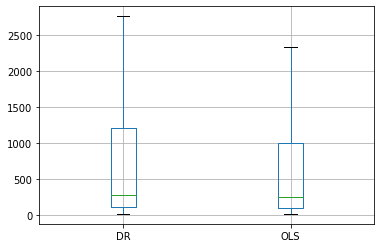

In [152]:
# plt.boxplot(x = 1, mise * 100, showfliers=False)
# plt.boxplot(x = 2, mise_ols * 100, showfliers=False)
pd.DataFrame({'DR' : mise * 100, 'OLS' : mise_ols * 100}).boxplot(showfliers = False)

In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymaltspro2 as pmp

In [26]:
dataset_iteration = 0
dataset_directory = './experiments/friedman_sim_dgp'
print(dataset_iteration, end = ' ')
seed = 2020 + 1000 * dataset_iteration

# read dataset
maltspro_df = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/X.csv')
y = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/Y.csv').to_numpy()

n_units = maltspro_df.shape[0]

np.random.seed(999)
    
# split into training and estimation datasets: 20% for training, 80% for estimation
train_indexes = np.random.choice(range(n_units), size = int(0.2 * n_units), replace = False)
est_indexes = list(set(range(n_units)) - set(train_indexes))
X_train = maltspro_df.iloc[train_indexes, :].reset_index()
X_est = maltspro_df.iloc[est_indexes, :].reset_index()
y_train = y[train_indexes, :]
y_est = y[est_indexes, :]

0 

In [27]:
with open(dataset_directory + '/dataset_' + str(seed) + '/malts_model.pkl', 'rb') as f:
    maltspro = pkl.load(f)

In [28]:
# get matched groups
mg_df = maltspro.get_matched_groups(X_estimation=X_est,
                                    Y_estimation= y_est,
                                    k =10)

# print(dataset_iteration, 'impute counterfactuals...', time.time())
# impute counterfactuals using barycenter of k nn
# y_bary = pmp.barycenter_imputation(pmp_self = maltspro, 
#                                 X_estimation=X_est,
#                                 Y_estimation= y_est,
#                                 MG = mg_df)

# print(dataset_iteration, 'estimate ITE...', time.time())


In [29]:
# def CATE(self, X_estimation, Y_estimation, reference_distribution, MG):
# 	CATE_array = []
# 	for i in X_estimation.index.values:
# 		# get treated units and outcomes that query unit is matched with
		
# 		treated_matched_unit_ids = MG.query('unit == ' + str(i)).query(self.treatment + ' != 1').matched_unit.values
# 		treated_matched_unit_oautcomes = Y_estimation[treated_matched_unit_ids, :]
# 		# get quantile function of treated barycenter given X= x_i
# 		y_treated = wasserstein2_barycenter(
# 			sample_array_1_through_n = treated_matched_unit_outcomes, 
# 			weights = np.repeat(1/treated_matched_unit_outcomes.shape[0], treated_matched_unit_outcomes.shape[0]),
# 			n_samples_min=self.n_samples_min,
# 			qtl_id=False
# 		)
		
# 		# get control units and outcomes that query unit is matched with
# 		control_matched_unit_ids = MG.query('unit == ' + str(i)).query(self.treatment + ' != 0').matched_unit.values
# 		control_matched_unit_outcomes = Y_estimation[control_matched_unit_ids, :]
# 		# get quantile function control barycenter given X = x_i
# 		y_control = wasserstein2_barycenter(
# 			sample_array_1_through_n = control_matched_unit_outcomes, 
# 			weights = np.repeat(1/control_matched_unit_outcomes.shape[0], control_matched_unit_outcomes.shape[0]),
# 			n_samples_min=self.n_samples_min,
# 			qtl_id=False
# 		)
# 		# get Y^{-1} \circ \lambda for treated and control outcomes
# 		y_lambda_treated = []
# 		y_lambda_control = []
# 		for i in reference_distribution[1, :]:
# 			y_lambda_treated.append(self.sample_quantile(quantile_fn = y_treated, quantile = i))
# 			y_lambda_control.append(self.sample_quantile(quantile_fn = y_control, quantile = i))

# 		y_lambda_treated = np.array(y_lambda_treated)
# 		y_lambda_control = np.array(y_lambda_control)
# 		# estimate CATE and append to list
# 		CATE_i = y_lambda_treated - y_lambda_control

# 		CATE_array.append(CATE_i)
# 	CATE_array = np.array(CATE_array).reshape([Y_estimation.shape[0], reference_distribution[1, :].shape[0]])
# 	return CATE_array


In [30]:
# # estimate CATEs with MALTS
# CATE_malts = maltspro.CATE(X_estimation = X_est,
#                       Y_estimation = y_est,
#                       reference_distribution = np.array([np.linspace(0, 1, maltspro.n_samples_min), np.linspace(0, 1, maltspro.n_samples_min)]),
#                       MG = mg_df)

In [42]:
dataset_directory = './experiments/quadratic_sim_dgp'
ITE_true = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/ITE.csv').to_numpy()
ITE_malts = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/maltspro_ITE.csv', index_col='Unnamed: 0').to_numpy()
ITE_ps = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/ps_ITE.csv', index_col='Unnamed: 0').to_numpy()
ITE_wass = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/wass_ols_ITE.csv', index_col='Unnamed: 0').to_numpy()
ITE_dr = pd.read_csv(dataset_directory + '/dataset_' + str(seed) + '/dr_rf_ITE.csv', index_col='Unnamed: 0').to_numpy()

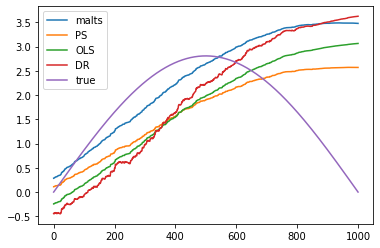

In [43]:
i = 4
plt.plot(ITE_malts[i, :], label = 'malts')
plt.plot(ITE_ps[i, :], label = 'PS')
plt.plot(ITE_wass[i, :], label = 'OLS')
plt.plot(ITE_dr[i, :], label = 'DR')
plt.plot(ITE_true[i, :], label = 'true')
plt.legend()

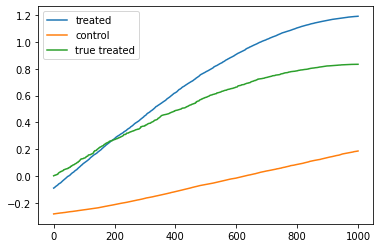

In [73]:
plt.plot(y_treated, label = 'treated')
plt.plot(y_control, label = 'control')
plt.plot(np.quantile(y_est[10, :], np.linspace(0, 1, maltspro.n_samples_min)), label = 'true treated')
plt.legend()

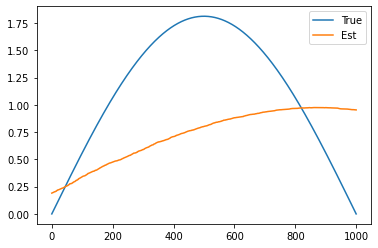

In [53]:
i = 16
plt.plot(ITE_malts[i, :], label = 'True')
plt.plot(CATE_malts[i, :], label = 'Est')
plt.legend()

In [21]:
# treated_units = mg_df.query('unit == 0').query('A == 1').matched_unit.values
# control_units = mg_df.query('unit == 0').query('A == 0').matched_unit.values
# y_treated = pmp.wasserstein2_barycenter(sample_array_1_through_n= y_est[treated_units, :], 
#                                         weights = np.repeat(1/treated_units.shape[0], treated_units.shape[0]),
#                                         n_samples_min=maltspro.n_samples_min,
#                                         array_quantiles=False)
# y_control = pmp.wasserstein2_barycenter(sample_array_1_through_n= y_est[control_units, :], 
#                                         weights = np.repeat(1/control_units.shape[0], control_units.shape[0]),
#                                         n_samples_min=maltspro.n_samples_min,
#                                         array_quantiles=False)


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb85579a2b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb85579a860>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb85579a048>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb85579ae10>],
 'fliers': [],
 'means': []}

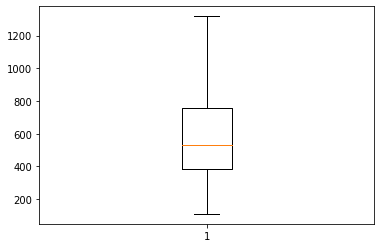

In [39]:
(plt.boxplot(((np.abs(CATE_malts - ITE_malts)).sum(axis = 1)/(np.abs(ITE_malts)).sum(axis = 1) * 100), showfliers=False))

In [74]:
mise = pd.read_csv(dataset_directory + '/mise.csv')

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb84e700208>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb84e7007b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb84e772f60>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb84e700d68>],
 'fliers': [],
 'means': []}

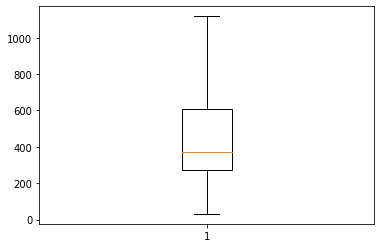

In [80]:
plt.boxplot(mise['DrOut MALTS'], showfliers = False)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb84e617e48>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb84e624438>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb84e617be0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb84e6249e8>],
 'fliers': [],
 'means': []}

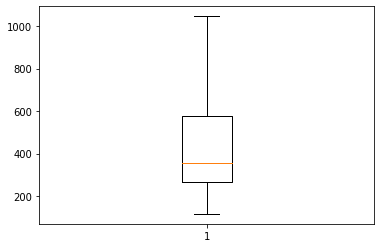

In [90]:
plt.boxplot((((ITE_malts - ITE_true)**2).sum(axis = 1))/((ITE_true**2).sum(axis = 1)) * 100, showfliers = False)